<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Burgers_tf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import requests
import scipy.io
import io

In [5]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {
    "font.family": "serif",              # Set default font family to serif
    "font.serif": ["Times New Roman"],   # Specify a default serif font
    "font.sans-serif": ["Helvetica"],    # Specify a default sans-serif font
    "font.monospace": ["Courier New"],   # Specify a default monospace font
    "axes.labelsize": 10,                # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,                # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),      # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join([
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
    ])
}

mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

Device mapping: no known devices.
It: 0, Loss: 6.166e+04, Time: 0.35
It: 100, Loss: 2.301e+04, Time: 2.69
It: 200, Loss: 8.522e+03, Time: 2.54
It: 300, Loss: 3.413e+03, Time: 1.85
It: 400, Loss: 2.153e+03, Time: 1.89
It: 500, Loss: 1.473e+03, Time: 1.89
It: 600, Loss: 1.087e+03, Time: 1.87
It: 700, Loss: 8.318e+02, Time: 1.53
It: 800, Loss: 6.438e+02, Time: 2.54
It: 900, Loss: 5.008e+02, Time: 1.89
It: 1000, Loss: 3.921e+02, Time: 1.48
It: 1100, Loss: 3.086e+02, Time: 1.50
It: 1200, Loss: 2.576e+02, Time: 1.50
It: 1300, Loss: 1.873e+02, Time: 1.49
It: 1400, Loss: 1.482e+02, Time: 1.47
It: 1500, Loss: 1.087e+02, Time: 1.50
It: 1600, Loss: 8.665e+01, Time: 2.49
It: 1700, Loss: 6.174e+01, Time: 1.96
It: 1800, Loss: 4.667e+01, Time: 1.49
It: 1900, Loss: 3.899e+01, Time: 1.52
It: 2000, Loss: 3.329e+01, Time: 1.49
It: 2100, Loss: 2.705e+01, Time: 1.50
It: 2200, Loss: 1.791e+01, Time: 1.50
It: 2300, Loss: 1.488e+01, Time: 1.49
It: 2400, Loss: 1.278e+01, Time: 2.45
It: 2500, Loss: 1.099e+01, T

<ipython-input-17-0ff4a622d677>:238: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize = 10)
<ipython-input-17-0ff4a622d677>:248: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize = 10)


Error: 2.561594e-03


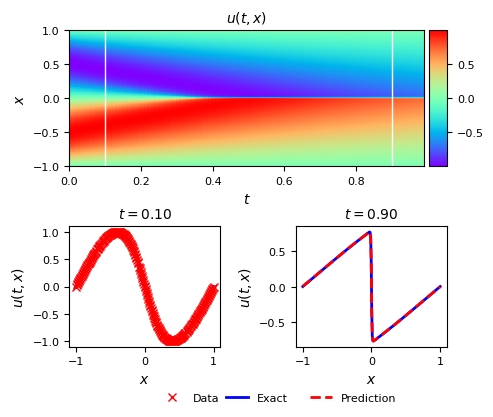

In [17]:
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

# Disable eager execution to use tf.compat.v1.placeholder
tf.compat.v1.disable_eager_execution()


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, x1, layers, dt, lb, ub, q):

        self.lb = lb
        self.ub = ub

        self.x0 = x0
        self.x1 = x1

        self.u0 = u0

        self.layers = layers
        self.dt = dt
        self.q = max(q,1)

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # Load IRK weights
        # Load IRK weights
        #tmp = np.float32(np.loadtxt('../../Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        url = f"https://raw.githubusercontent.com/maziarraissi/PINNs/master/Utilities/IRK_weights/Butcher_IRK{q}.txt"
        response = requests.get(url)
        response.raise_for_status()

        tmp = np.loadtxt(io.StringIO(response.text), ndmin=2).astype(np.float32)
        self.IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
        self.IRK_times = tmp[q**2+q:]

        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x0_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, self.x0.shape[1]))
        self.x1_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, self.x1.shape[1]))
        self.u0_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, self.u0.shape[1]))
        self.dummy_x0_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, self.q)) # dummy variable for fwd_gradients
        self.dummy_x1_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, self.q+1)) # dummy variable for fwd_gradients

        self.U0_pred = self.net_U0(self.x0_tf) # N x (q+1)
        self.U1_pred = self.net_U1(self.x1_tf) # N1 x (q+1)

        self.loss = tf.reduce_sum(tf.square(self.u0_tf - self.U0_pred)) + \
                    tf.reduce_sum(tf.square(self.U1_pred))

        # self.optimizer = ScipyOptimizerInterface(self.loss,
        #                                          method='L-BFGS-B',
        #                                          options={'maxiter': 50000,
        #                                                   'maxfun': 50000,
        #                                                   'maxcor': 50,
        #                                                   'maxls': 50,
        #                                                   'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def fwd_gradients_0(self, U, x):
        g = tf.gradients(U, x, grad_ys=self.dummy_x0_tf)[0]
        return tf.gradients(g, self.dummy_x0_tf)[0]

    def fwd_gradients_1(self, U, x):
        g = tf.gradients(U, x, grad_ys=self.dummy_x1_tf)[0]
        return tf.gradients(g, self.dummy_x1_tf)[0]

    def net_U0(self, x):
        nu = 0.01/np.pi
        U1 = self.neural_net(x, self.weights, self.biases)
        U = U1[:,:-1]
        U_x = self.fwd_gradients_0(U, x)
        U_xx = self.fwd_gradients_0(U_x, x)
        F = -U*U_x + nu*U_xx
        U0 = U1 - self.dt*tf.matmul(F, self.IRK_weights.T)
        return U0

    def net_U1(self, x):
        U1 = self.neural_net(x, self.weights, self.biases)
        return U1 # N x (q+1)

    def callback(self, loss):
        print('Loss:', loss)

    def train(self, nIter):
        tf_dict = {self.x0_tf: self.x0, self.u0_tf: self.u0, self.x1_tf: self.x1,
                   self.dummy_x0_tf: np.ones((self.x0.shape[0], self.q)),
                   self.dummy_x1_tf: np.ones((self.x1.shape[0], self.q+1))}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if it % 1000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()

        # self.optimizer.minimize(self.sess,
        #                         feed_dict=tf_dict,
        #                         fetches=[self.loss],
        #                         loss_callback=self.callback)

    def predict(self, x_star):

        U1_star = self.sess.run(self.U1_pred, {self.x1_tf: x_star})

        return U1_star



q = 500
layers = [1, 50, 50, 50, q+1]
lb = np.array([-1.0])
ub = np.array([1.0])

N = 250

url = "https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat"

# Step 2: Download the file content
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Step 3: Load the .mat file into memory
data = scipy.io.loadmat(io.BytesIO(response.content))

t = data['t'].flatten()[:,None] # T x 1
x = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['usol']).T # T x N

idx_t0 = 10
idx_t1 = 90
dt = t[idx_t1] - t[idx_t0]

# Initial data
noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[1], N, replace=False)
x0 = x[idx_x,:]
u0 = Exact[idx_t0:idx_t0+1,idx_x].T
u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])


# Boudanry data
x1 = np.vstack((lb,ub))

# Test data
x_star = x

model = PhysicsInformedNN(x0, u0, x1, layers, dt, lb, ub, q)
model.train(10000)

U1_pred = model.predict(x_star)

error = np.linalg.norm(U1_pred[:,-1] - Exact[idx_t1,:], 2)/np.linalg.norm(Exact[idx_t1,:], 2)
print('Error: %e' % (error))

######################################################################
############################# Plotting ###############################
######################################################################

fig, ax = newfig(1.0, 1.2)
ax.axis('off')

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2 + 0.1, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x_star.min(), x_star.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[idx_t0]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[idx_t1]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)


####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-1/2-0.05, bottom=0.15, left=0.15, right=0.85, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[idx_t0,:], 'b-', linewidth = 2)
ax.plot(x0, u0, 'rx', linewidth = 2, label = 'Data')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = %.2f$' % (t[idx_t0]), fontsize = 10)
ax.set_xlim([lb-0.1, ub+0.1])
ax.legend(loc='upper center', bbox_to_anchor=(0.8, -0.3), ncol=2, frameon=False)


ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[idx_t1,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x_star, U1_pred[:,-1], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = %.2f$' % (t[idx_t1]), fontsize = 10)
ax.set_xlim([lb-0.1, ub+0.1])

ax.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)


# savefig('./figures/Burgers')